In [2]:
from scipy import misc, sparse
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from skimage import io
import warnings
import json
warnings.filterwarnings('ignore')
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry.point import Point
import pickle
from itertools import compress
from ast import literal_eval

from IPython.display import display, HTML


colorsHex = [
    '#FFFFFF',
    '#E4E4E4',
    '#888888',
    '#222222',
    '#FFA7D1',
    '#E50000',
    '#E59500',
    '#A06A42',
    '#E5D900',
    '#94E044',
    '#02BE01',
    '#00E5F0',
    '#0083C7',
    '#0000EA',
    '#E04AFF',
    '#820080'
]


def HexToRGB(hexStr):
    return tuple(int(hexStr.strip('#')[i:i+2], 16) for i in (0, 2 ,4))

def RGBToHex(value):
    return ('#%02x%02x%02x' % (value[0], value[1], value[2])).upper()

def idxToHex(idx):
    return colorsHex[idx]

def idxToRGB(idx):
    return HexToRGB(colorsHex[idx])

def HexToIdx(hexStr):
    return colorsHex.index(hexStr)

def RGBToIdx(rgb):
    return HexToIdx(RGBToHex(rgb))

def showImage(image, size=(12,12), ax=None):
    if not ax:
        _, ax = plt.subplots(1,1, figsize=size)
    ax.imshow(image.transpose((1,0,2)), interpolation='nearest')
    ax.grid(False)
    
def canvas_idx_to_rgb(canvas):
    canvas_final = np.ones((canvas.shape[0],canvas.shape[1], 3), dtype=np.int64)*255
    for x in range(canvas.shape[0]):
        for y in range(canvas.shape[1]):
            canvas_final[x,y] = idxToRGB(canvas[x,y])
    return canvas_final

We first define the minimum area of a shape in order to be considered, the idea is that conflict will be more visible on big areas (and involve more people)

In general, I packed the coordinate to be more memory efficient, that is the coordinate now range from 0 to `1'000*1'000+1'000 = 1'001'000`, so `packed_coord = x*1000+y`, in order to unpack `x=packed_coord//1000` and `y=packed_coord%1000`

There are several data structures, the one of interest are
- `atlas_with_poly` that contains all the shape contained in the atlas with a polygon and a size of at least the threshold, it contains pretty much everything, including the name, subreddit, etc.
- `polys_packed` that contains a list of coordinates in the packed format for each polyhon
- `dataset` which contains the point, filtered to only keep those present in the polygons described above, with the timestamp normalized to the second (and starting from 0), the timestamp in minute and hour. It also contains a "correct" boolean, which states if the pixel placed is correct regarding the corrected version of the canvas.

In [3]:
area_threshold = 1000

dataset = pd.read_csv("dataset/tile_placements.csv")
dataset = dataset[(dataset['x_coordinate'] < 1000) & (dataset['y_coordinate'] < 1000)]

dataset['coordinates_packed'] = dataset['x_coordinate'] * 1000 + dataset['y_coordinate']

dataset.drop(columns=['x_coordinate', 'y_coordinate'], inplace=True)
# dataset['coordinates'] = list(zip(dataset['x_coordinate'], dataset['y_coordinate']))

canvas_corr = np.load('canvas_corr_idx.npy')
canvas_final = np.load('canvas_final_idx.npy')

with open('atlas/atlas_with_mask.pickle', 'rb') as infile:
    atlas = pickle.load(infile)

atlas_with_poly = [poly for poly in atlas if 'poly_mask' in poly and len(poly['poly_mask'][0]) > area_threshold]

id2Idx = {shape['id']: idx for idx, shape in enumerate(atlas_with_poly)}
idx2Id = {v: k for k,v in id2Idx.items()}

polys = [np.array(shape['poly_mask']) for shape in atlas_with_poly]

polys_packed = [poly[0]*1000+poly[1] for poly in polys]

valid_coords = list(set([tup[0]*1000+tup[1] for poly in polys for tup in list(map(tuple, poly.T))]))

dataset =  dataset[dataset['coordinates_packed'].isin(valid_coords)]

dataset['user'] = dataset['user'].astype('category')

starting_ts = int(dataset['ts'].min())
dataset['ts'] = (dataset['ts']-starting_ts)//1000

color_correctness = []
for ts, _, color, coords in dataset.values:
    x, y = coords//1000, coords%1000
    color_correctness.append(canvas_corr[x,y] == color)
color_correctness = np.array(color_correctness)
dataset['correct'] = color_correctness
dataset['ts_hour'] = dataset['ts']//3600
dataset['ts_minute'] = dataset['ts']//60

Function below is used to retrieve the area in pixel squared of some zone of interests on the canva. Not really on the flow of the rest of the notebook, I just put it there since starting from the cell above I have access to the data structure holding all polys. 

Best regards,

_Cédric Viaccoz_

In [38]:
import re

def print_area_by_name(subreddit_name, flexible=False):
    right_poly = [poly for poly in atlas_with_poly \
                  if subreddit_name.lower() in [x.strip().strip('/').lstrip('r/').lower() for x in poly['subreddit'].split(',')]]
    poly_nmb = len(right_poly)
    if poly_nmb == 0:
        raise ValueError('The subreddit name provided \"%s\" either is not contained in the atlas, or has a typo'\
                         %(subreddit_name))
    elif poly_nmb > 1 and not flexible:
        raise ValueError('Too many polygons were found for this subreddit : \"%s\"'%(subreddit_name))
    else:
        area = 0
        if not flexible:
            area = right_poly[0]['poly'].area
        else:
            for p in right_poly:
                area += p['poly'].area
        print('\"%s\"\'s area is %.1lf'%\
             (subreddit_name, area))

        
areas_of_interest = [
    'americanflaginplace',
    'sweden',
    'denmark',
    'norge',
    'thefarleftside',
    'theblackvoid',
    'europe',
    'ainbowroad',
    'de',
    'placede',
    'stlouisblues',
    'ireland',
    'purplepixels',
    'osugame',
    'placenl',
    'placestart',
    'placehearts',
    'thebluecorner'
    

]

for name in areas_of_interest:
    print_area_by_name(name, flexible=True)

"americanflaginplace"'s area is 12116.0
"sweden"'s area is 18047.5
"denmark"'s area is 7443.5
"norge"'s area is 11788.5
"thefarleftside"'s area is 1091.5
"theblackvoid"'s area is 11122.5
"europe"'s area is 4830.0
"ainbowroad"'s area is 105079.5
"de"'s area is 18806.5
"placede"'s area is 18806.5
"stlouisblues"'s area is 1752.5
"ireland"'s area is 10050.5
"purplepixels"'s area is 4978.0
"osugame"'s area is 6204.5
"placenl"'s area is 42235.0
"placestart"'s area is 15195.5
"placehearts"'s area is 18678.0
"thebluecorner"'s area is 6946.0


Helper function to plot the ratio of good pixel by second/minute/hour. Because of the construction of the "correct" field, the ratio is equivalent to the mean of correct pixels in a particular time.

In [9]:
def plot_conflict_ration(filtering=np.array([True] * len(dataset)), title=""):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    dataset[filtering].groupby('ts')['correct'].mean().plot(ax=axes[0][0])
    dataset[filtering].groupby('ts_minute')['correct'].mean().plot(ax=axes[0][1])
    dataset[filtering].groupby('ts_hour')['correct'].mean().plot(ax=axes[1][0])
    axes[-1, -1].axis('off')

    plt.suptitle(title + ' conflict ratio', fontsize=16)
    plt.subplots_adjust(top=10)
    fig.text(0.5, -0.001, 'Time', ha='center', size=14)
    fig.text(-0.01, 0.5, 'Conflict ratio', va='center', rotation='vertical', size=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

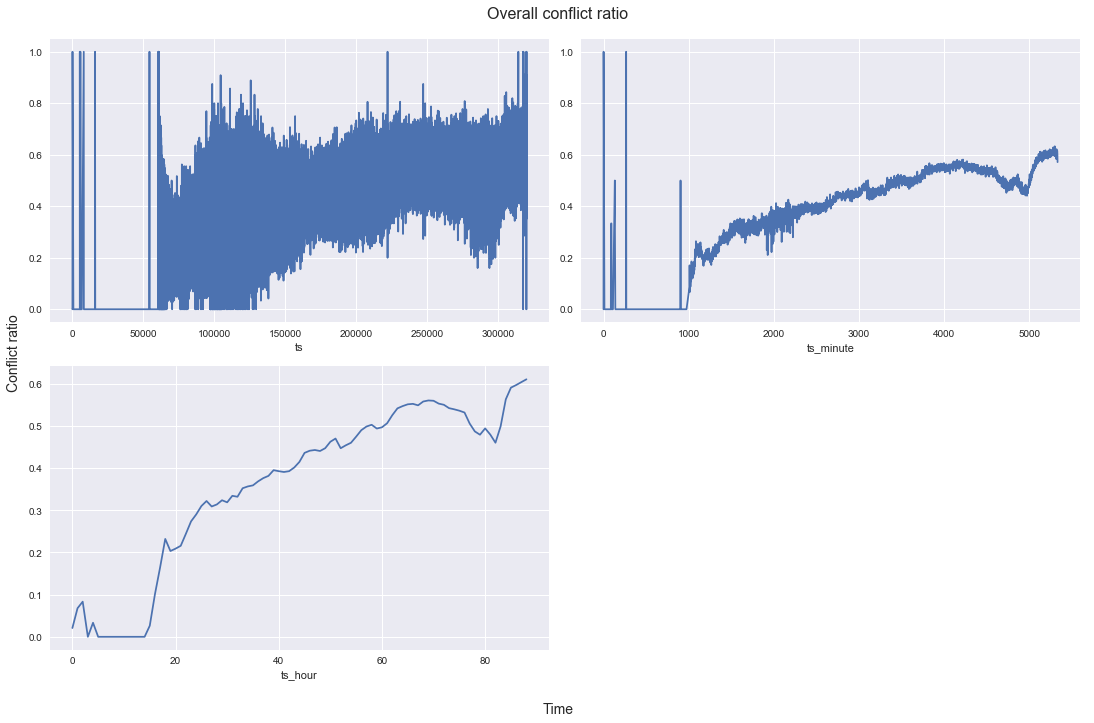

In [11]:
plot_conflict_ration(title='Overall')

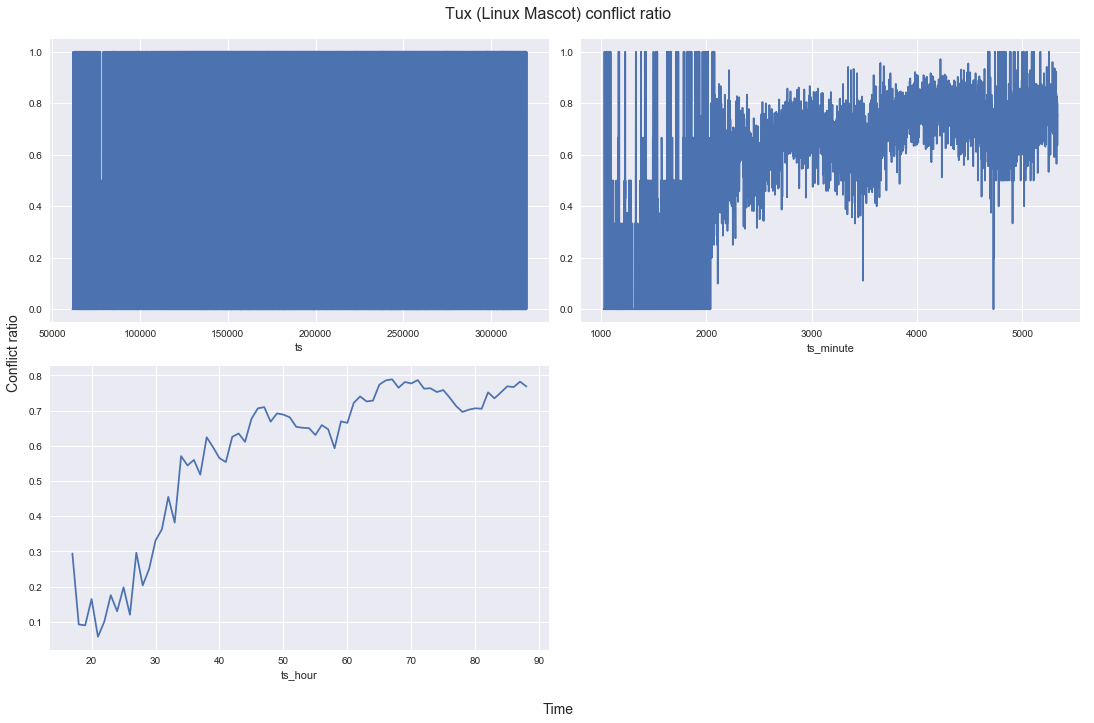

In [12]:
plot_conflict_ration(dataset['coordinates_packed'].isin(polys_packed[0]), title=atlas_with_poly[0]['name'])

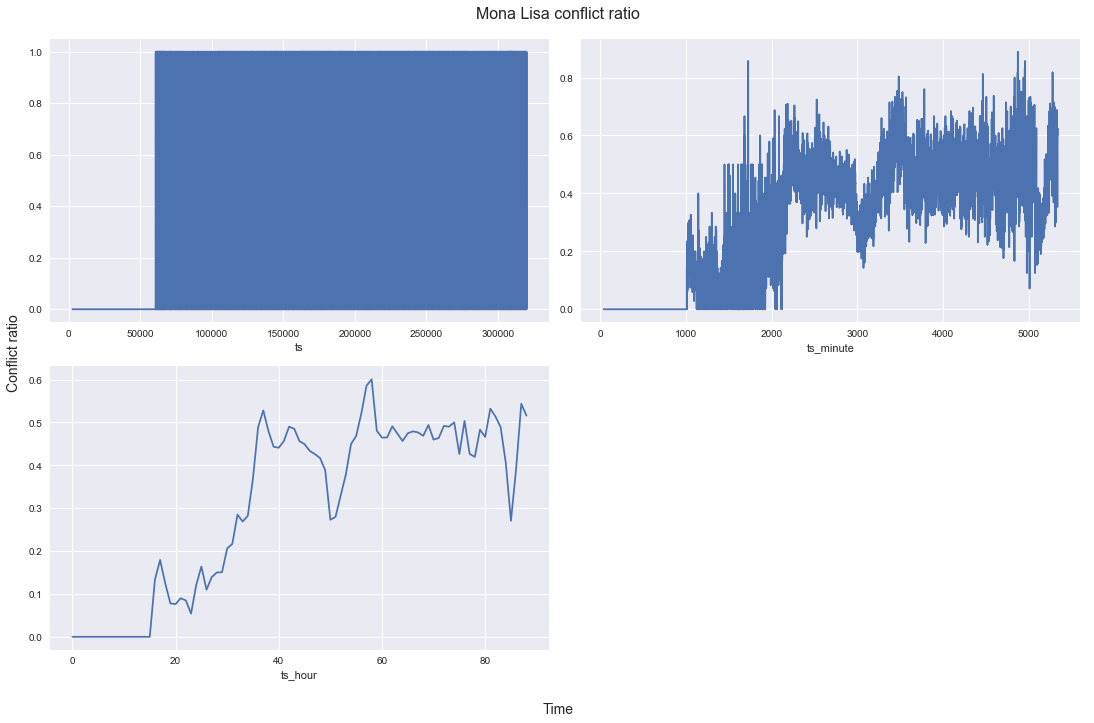

In [13]:
plot_conflict_ration(dataset['coordinates_packed'].isin(polys_packed[1]), title=atlas_with_poly[1]['name'])

## User subreddits

We first create a dataframe that contains the subreddits to which a coordinate belongs

In [14]:
packedCoord2Subreddits = {}
for idx, poly in enumerate(polys_packed):
    sub_names = [x.strip().lower() for x in atlas_with_poly[idx]['subreddit'].split(',')]
    for i in range(len(atlas_with_poly[idx]['poly_mask'][0])):
        packed_coord = atlas_with_poly[idx]['poly_mask'][0][i]*1000+atlas_with_poly[idx]['poly_mask'][1][i]
        if not packed_coord in packedCoord2Subreddits:
            packedCoord2Subreddits[packed_coord] = []
        packedCoord2Subreddits[packed_coord].extend(sub_names)
packed_coord_subreddit_df = pd.DataFrame([[packed_coord, sub] for packed_coord, subs in packedCoord2Subreddits.items() for sub in subs], columns=['coordinates_packed', 'subreddit']).set_index('coordinates_packed')

We then map each action to a subreddit by joining the coordinate per subreddit.

Note that it will have the effect of duplicating the entry if a pixel belongs to several subreddits.

In [15]:
dataset_flat = dataset.set_index("coordinates_packed").join(packed_coord_subreddit_df).reset_index()
dataset_flat['user'] = dataset_flat['user'].astype('category')
dataset_flat['subreddit'] = dataset_flat['subreddit'].astype('category')
dataset_flat['incorrect'] = 1-dataset_flat['correct']
dataset_flat['direction'] = dataset_flat['correct']*2-1

dataset_flat.head()

,coordinates_packed,ts,user,color,correct,ts_hour,ts_minute,subreddit,incorrect,direction
0,38,248619,NbHA5m8Sr15Dhcyy+o+YIOfGI0Y=,3,True,69,4143,/r/purplepixels,0,1
1,38,201675,FJfrFcqvp4AbOzoeIzOwKIXSADY=,15,False,56,3361,/r/purplepixels,1,-1
2,38,292720,63UJT/arm5DObCrz7skxy5l/2HE=,3,True,81,4878,/r/purplepixels,0,1
3,38,237387,pKn9bV9XLpOpTl7/dI372HoCyxU=,0,False,65,3956,/r/purplepixels,1,-1
4,38,225479,X0jeGT/cxC7X8dmeisclEDChuaE=,8,False,62,3757,/r/purplepixels,1,-1


OR

In [ ]:
dataset_flat = pd.read_csv('dataset/tile_placements_area_1000_flat.csv', index_col=0)
dataset_flat['user'] = dataset_flat['user'].astype('category')
dataset_flat['subreddit'] = dataset_flat['subreddit'].astype('category')
dataset_flat['incorrect'] = 1-dataset_flat['correct']
dataset_flat['direction'] = dataset_flat['correct']*2-1

dataset_flat.head()

### Analysis

We first only consider positive and negative action, without considering action that negated another one. E.g. a user place a good pixel for a subreddit, but then placed a bad pixel for this community, then maybe negate the whole contribution (sum of action = 0), but this approach does not takes that into account.

In [16]:
threshold = 10

Showing stats for big positive and negative action (less chance of it being spam)

In [17]:
user_subreddit_positive = dataset_flat.groupby(['user', 'subreddit'])['correct'].sum()
big_positive = user_subreddit_positive[(user_subreddit_positive >= threshold)]

user_subreddit_positive.describe(percentiles=[.25, .5, .75, .80, .90, .99, .999])

count    4.693011e+06
mean     1.807867e+00
std      7.187640e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
80%      1.000000e+00
90%      3.000000e+00
99%      3.000000e+01
99.9%    9.400000e+01
max      6.130000e+02
Name: correct, dtype: float64

In [18]:
user_subreddit_negative = dataset_flat.groupby(['user', 'subreddit'])['incorrect'].sum()
big_negative = user_subreddit_negative[(user_subreddit_negative >= threshold)]

user_subreddit_negative.describe(percentiles=[.25, .5, .75, .80, .90, .99, .999])

count    4.693011e+06
mean     2.083666e+00
std      5.906543e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
80%      2.000000e+00
90%      4.000000e+00
99%      2.400000e+01
99.9%    7.300000e+01
max      4.740000e+02
Name: incorrect, dtype: float64

Among the significant action, we make a ranking of subreddit by number of user contributing significantly (positively and negatively)

In [19]:
positive_users = big_positive.index.get_level_values(0)
negative_users = big_negative.index.get_level_values(0)
mixed_users = positive_users.intersection(negative_users)

In [21]:
max_display = 20
with pd.option_context('display.max_rows', max_display):
    display(big_positive.loc[list(set(positive_users.astype('str').values))].reset_index()
         .groupby('subreddit').size().sort_values(ascending=False).to_frame().head(max_display))

,0
subreddit,
r/ainbowroad,9330
/r/americanflaginplace,9317
/r/osugame/,5392
/r/placenl,4523
/r/canada,4505
/r/sweden,4503
/r/de,4147
/r/placede,4147
/r/thebluecorner,3802


In [22]:
with pd.option_context('display.max_rows', max_display):
    display(big_negative.loc[list(set(negative_users.astype('str').values))].reset_index()
         .groupby('subreddit').size().sort_values(ascending=False).to_frame().head(max_display))

,0
subreddit,
r/ainbowroad,12408
/r/osugame/,7036
/r/placenl,6825
/r/americanflaginplace,5289
/r/thegreatblackhole,4362
/r/placestart,3609
/r/tfls,3608
,3453
/r/canada,3331


### Overall

Now taking into account the sum of action of each user.

In [23]:
min_pixels = 10

In [24]:
user_subreddit_overall = dataset_flat.groupby(['user', 'subreddit'])['direction'].sum()
user_subreddit_overall.describe(percentiles=[.25, .5, .75, .80, .90, .99, .999])

count    4.693011e+06
mean    -2.757991e-01
std      7.533115e+00
min     -4.730000e+02
25%     -1.000000e+00
50%     -1.000000e+00
75%      1.000000e+00
80%      1.000000e+00
90%      2.000000e+00
99%      2.100000e+01
99.9%    7.300000e+01
max      5.470000e+02
Name: direction, dtype: float64

In [25]:
big_overall = user_subreddit_overall[(user_subreddit_overall >= min_pixels) | (user_subreddit_overall <= -min_pixels)]
big_overall_positive = user_subreddit_overall[(user_subreddit_overall >= min_pixels)]
big_overall_negative = user_subreddit_overall[(user_subreddit_overall <= -min_pixels)]

positive_overall_users = big_overall_positive.index.get_level_values(0)
negative_overall_users = big_overall_negative.index.get_level_values(0)

In [26]:
max_display = 20
with pd.option_context('display.max_rows', max_display):
    display(big_overall_positive.loc[list(set(positive_overall_users.astype('str').values))].reset_index()
         .groupby('subreddit').size().sort_values(ascending=False).to_frame().head(max_display))

,0
subreddit,
/r/americanflaginplace,8216
r/ainbowroad,4140
/r/osugame/,3899
/r/sweden,3753
/r/thebluecorner,3424
/r/orderofthebluecorner,3424
/r/canada,3051
/r/prequelmemes,2757
/r/placenl,2648


In [27]:
with pd.option_context('display.max_rows', max_display):
    display(big_overall_negative.loc[list(set(negative_overall_users.astype('str').values))].reset_index()
         .groupby('subreddit').size().sort_values(ascending=False).to_frame().head(max_display))

,0
subreddit,
r/ainbowroad,6265
/r/osugame/,4899
/r/americanflaginplace,4103
/r/placenl,3820
/r/thegreatblackhole,2682
,2539
/r/thebluecorner,2539
/r/orderofthebluecorner,2539
/r/placestart,2471


We now extract "mixed" users, i.e. users having done big positive AND negative actions, we then figure out their "camps" and can thus analyze the conflicts

In [28]:
mixed_overall_users = positive_overall_users.intersection(negative_overall_users)

mixed_users_camps = big_overall.loc[list(set(mixed_overall_users.astype('str').values))].reset_index(level=1)
positive_actions = mixed_users_camps[mixed_users_camps['direction'] > 0]['subreddit']
negative_actions = mixed_users_camps[mixed_users_camps['direction'] < 0]['subreddit']
df_camps = positive_actions.to_frame().rename(columns={'subreddit': 'positive_subreddit'})\
    .join(negative_actions.to_frame().rename(columns={'subreddit': 'negative_subreddit'}))

In [31]:
with pd.option_context('display.max_rows', 1000):
    display(df_camps.groupby(['positive_subreddit', 'negative_subreddit'])
                .size().reset_index().sort_values(by=0, ascending=False).reset_index().head(1000))

,index,positive_subreddit,negative_subreddit,0
0,6421,/r/sweden,r/denmark,382
1,572,/r/americanflaginplace,r/ainbowroad,247
2,4413,/r/osugame/,/r/placestart,171
3,4433,/r/osugame/,/r/stlouis/,154
4,548,/r/americanflaginplace,/r/tfls,146
5,4434,/r/osugame/,/r/stlouisblues,136
6,499,/r/americanflaginplace,/r/norge,136
7,1569,/r/de,/r/europe,127
8,4721,/r/placede,/r/europe,127
9,519,/r/americanflaginplace,/r/purplepixels,117


Since some communities attract all the conflict, we filter them out to better see smaller conflicts.

We remove the empty string community, which correspond to shape with no subreddit.

In [32]:
def create_filter(strings):
    filtering = df_camps.positive_subreddit.str.contains("")
    for string in strings:
        filtering = (filtering &
                     ~df_camps.positive_subreddit.str.contains(string) &
                     ~df_camps.negative_subreddit.str.contains(string))
    return filtering

filter_communities = create_filter([" "])

In [33]:
with pd.option_context('display.max_rows', 1000):
    display(df_camps[(df_camps.positive_subreddit.str.len() > 0) & (df_camps.negative_subreddit.str.len() > 0)].groupby(['positive_subreddit', 'negative_subreddit'])
                .size().reset_index().sort_values(by=0, ascending=False).reset_index().head(1000))

,index,positive_subreddit,negative_subreddit,0
0,6231,/r/sweden,r/denmark,382
1,465,/r/americanflaginplace,r/ainbowroad,247
2,4245,/r/osugame/,/r/placestart,171
3,4265,/r/osugame/,/r/stlouis/,154
4,441,/r/americanflaginplace,/r/tfls,146
5,392,/r/americanflaginplace,/r/norge,136
6,4266,/r/osugame/,/r/stlouisblues,136
7,4550,/r/placede,/r/europe,127
8,1446,/r/de,/r/europe,127
9,412,/r/americanflaginplace,/r/purplepixels,117


### Spatial Hypothesis rundown

(again by CV, not Raph', don't blame him for this bastard code)

Some further small data analysis need to be done to understand is the "spatial conflict" hypothesis hold any truth.

In [37]:
with pd.option_context('display.max_rows', 1000):
    display(df_camps[(df_camps.positive_subreddit.str.len() > 0) & (df_camps.negative_subreddit.str.len() > 0)].groupby(['positive_subreddit', 'negative_subreddit'])
                .size().reset_index().groupby(['negative_subreddit']).size().reset_index().sort_values(by=0, ascending=False).reset_index().head(100))

,index,negative_subreddit,0
0,202,r/ainbowroad,172
1,5,/r/americanflaginplace,159
2,129,/r/placenl,151
3,118,/r/osugame/,136
4,179,/r/thegreatblackhole,134
5,167,/r/sweden,129
6,131,/r/placestart,129
7,128,/r/placehearts,127
8,176,/r/thebluecorner,125
9,117,/r/orderofthebluecorner,125


Now it would be great to make data that actually depicts that all those communities have high area. Like appending the index of ranking from the biggest subreddit to this dataframe.

In [40]:
dataset.head()

,ts,user,color,coordinates_packed,correct,ts_hour,ts_minute
0,249150,c2Md9m4QckH8M+lhNh9btgoiFDk=,0,326258,True,69,4152
1,252963,5KjCuLCk/VTXBIgaszopYecZ3uU=,0,190791,False,70,4216
3,317173,TGENUMJ6VmaBRr8ae9yP0MWQ66g=,0,233931,True,88,5286
4,244491,usR8PLvN90gdivTbszEqhvPcXI4=,0,526663,True,67,4074
5,130905,PhCeV35qg+Kd4HZH2A8YsmwE65w=,0,578327,True,36,2181
